<a href="https://colab.research.google.com/github/envil/plda-pmf/blob/develop/Viet_Ta_BAY2_ReportForm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayensian Inference 1: Project Report

---



### Title: "Detecting protein count baseline of CITE-seq technique using protein modeling task"

### Name: "Viet Ta (299954)"


## Abstract

CITE-seq count data is mixed with noise, which make the zero counts become non-zero values. By using Estimation-Maximization (EM) with Gaussian Mixture Model (GMM), we can infer the baseline value which threshold the count value for whether the protein is present or not present in the cells.

## Introduction
### Problem statement
Protein modeling task. CITE-seq technique can extract at the same time estimate of the protein on the surface of the cell and RNA-seq gene counts. As with all biological data, this data is also very noisy. However, dropout events are not present as in the task 2. But the task is to detect the baseline protein measurement per protein. For example, if the the baseline 10, then for all cells where the count is below 10, we would say that protein is not present at the surface of the cell. This is also not a binary (present/ not-present) thing, sometimes cells can have more of the same protein so the counts are bigger. This might indicate a bigger cell (so cell-types can could be also potentially be differentiated from these protein measurements).

### Dataset
Protein count data observed from CITE-seq techinque: the protein on the surface of the cell and RNA-seq gene counts. Data can be found here: https://drive.google.com/open?id=1Cqc71ootZFdE1xyDH5OlD5pIpWchfF84

The dataframe has two dimensions:
- Each row has the protein count of one cell. The cell column represents the cells' names. Each consists of two parts seperated by a dot: **ABC99999.A99**. The first part is the cell type, the second part is the counting of the cell belong to that type.
- Each column has the count data of one type of protein over all the cells.

As any biological data, in this case it's mixed with noise. The consequence is that if one protein is not present in one type of cell, the count number is still a non-zero number. Hence, we need to detect the baseline which is the value that we consider the protein count basically mean zero and that protein is not present in the cell.
### Hypothesis
One hypotheis is that the count and the noise follow Gaussian distribution, so we will try to fit a 2-component Gausian Mixture Model to see if there's any kind of distribution that we will be interested in. Hopefully, the noise and the meaningful data will be seperated.
### Gaussian Mixture Model
A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset [1]. GMM is very similar to k-means but contains probabilistic model under the hood. It uses an expectation-maximization (EM) approach:

- Choose starting guesses for the location and shape
- Repeat until converged:
 - *E-step*: for each data point, find weights encoding the probability of membership in each component
 - *M-step*: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights
 
So instead of drawing hard edged to define the components like in k-means, GMM form a smooth Gaussian model to represent the data distribution. This give GMM a vastly better flexibilty in fitting the data in the model. 

### Programming Language & Libraries
- Language used: Python
- Libraries:
 - Scikit-learn: free software machine learning library for the Python programming language. Has built-in GMM.
 - SciPy: free and open-source Python library used for scientific computing and technical computing. This includes NumPy and pandas: two data library.
 - Seaborn: plotting library.
 
### Goal after finishing the project
* Solved the problem
* Have a peak on how to solve real problems with machine learning, Bayesian inference.

## Methods

In [0]:
# setup
!pip install daft seaborn PyDrive

### Dataset description and processing

Variables in the dataset:
- Number of components ($c$): deterministic variable, we suppose there're 2 components
- Number of sample ($n$): deterministic variable, gausian distributed, observed
- Categorical assignment of whether one protein is present/not present in one type of cell ($\theta$): latent variable, Dirichlet distribution
- Categorical concentration of $\theta$ ($\alpha$): latent variable
- Mean of the count data ($\mu$): random variable, latent variable
- Variance of the count data ($\sigma$): random variable, latent variable

### Generative Process

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


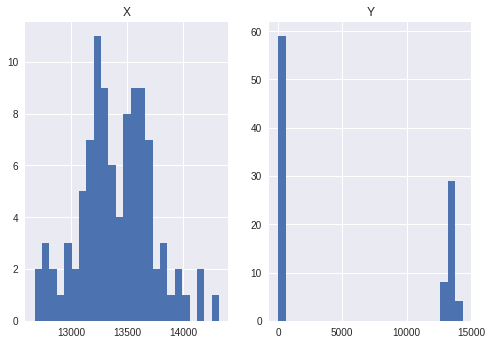

In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt

sess = tf.InteractiveSession()

# number of component
c = 2
# number of sample
n = 100

# actual data
mu = random.randint(1000, 20000)
sigma = random.randint(100, 1000)
x = np.random.normal(loc=mu, scale=sigma, size=n)

# not present assignment
theta = np.random.randint(0, 2, n)

# noise data
mu_2 = random.randint(50, 100)
sigma_2 = random.randint(1, 20)
noise = np.random.normal(loc=mu_2, scale=sigma_2, size=n)

# mixing data and nosie
y = x * theta + noise

# plotting the data
plt.subplot(1, 2, 1)
plt.hist(x, bins=25)
plt.title("X")
plt.subplot(1, 2, 2)
plt.hist(y, bins=25)
_ = plt.title("Y")

### Accquiring Data & Visualization
In this step I simply get the data from Google Drive and read the data.
After that, I plot the histogram of the protein count over all the cells, and some correlations between the pairs by plotting the pair plots. 

/usr/local/lib/python3.6/dist-packages/google/colab/auth.py:140: ResourceWarning: unclosed <ssl.SSLSocket fd=92, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 36666), raddr=('74.125.20.84', 443)>
  if _check_adc():


                CD20          CD45          CD34          CD10          CD19
count     338.000000    338.000000    338.000000    338.000000    338.000000
mean    23072.244988   5127.245055  11149.722787  21958.167775   7646.466669
std     38287.169028   5237.689210  10042.226757  13717.425844   6457.032275
min         0.000000      0.000000      0.000000      0.000000      0.000000
25%      1267.457500   1761.627500   2203.292500  14393.900000   3040.920000
50%      1819.555000   3147.340000   7368.095000  23074.900000   5438.420000
75%     32328.200000   6055.180000  18973.900000  31009.525000  10816.500000
max    281079.000000  31063.500000  45108.700000  66375.100000  34352.300000


/usr/local/lib/python3.6/dist-packages/matplotlib/artist.py:315: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 39094), raddr=('74.125.142.95', 443)>
  for oid, func in self._propobservers.items():
/usr/lib/python3.6/contextlib.py:60: ResourceWarning: unclosed <ssl.SSLSocket fd=78, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 50496), raddr=('74.125.195.95', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.6/contextlib.py:60: ResourceWarning: unclosed <ssl.SSLSocket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 38616), raddr=('74.125.142.95', 443)>
  self.gen = func(*args, **kwds)
/usr/lib/python3.6/contextlib.py:60: ResourceWarning: unclosed <ssl.SSLSocket fd=80, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 58518), raddr=('74.125.142.132', 443)>
  self.ge

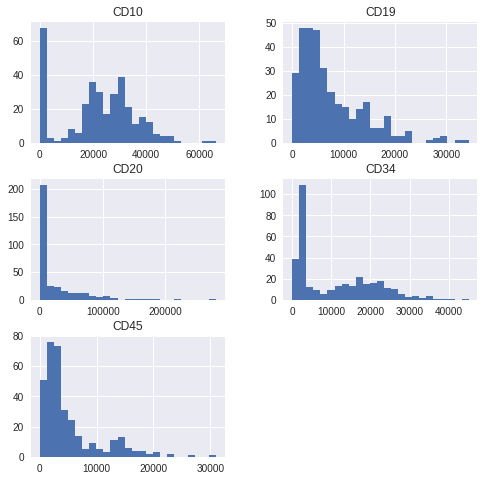

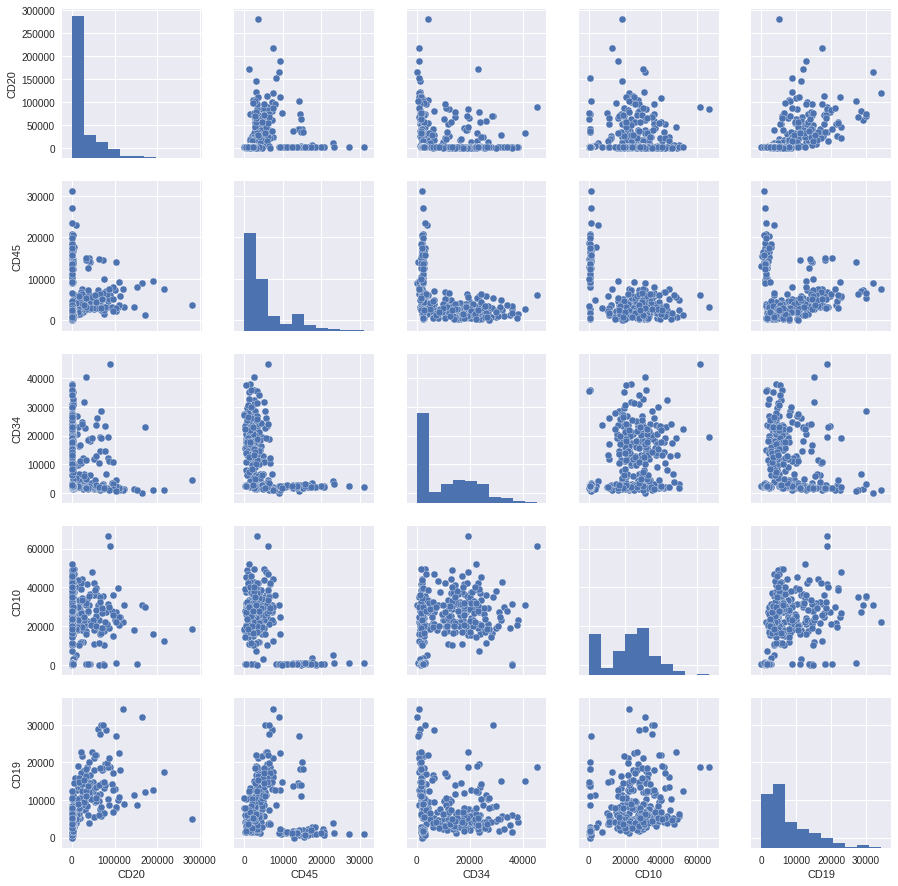

In [0]:
from numpy import genfromtxt
import seaborn as sns
import scipy as sp

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# 2. Load a file by ID and print its contents.
downloaded = drive.CreateFile({'id': "1Cqc71ootZFdE1xyDH5OlD5pIpWchfF84"})
downloaded.GetContentFile('protein.csv')

protein = pd.read_csv('protein.csv', sep=",")
print(protein.describe())

_ = protein.hist(figsize=(8, 8), bins=25)
_ = sns.pairplot(protein)

By looking with eyes, we can see that the distribution form is not clear for example with protein CD19 or CD20. This might be because of the fact that the size of the cells vary by cel types. This will make the histogram looks bad and we want to avoid this.
### Processing data
To avoid the problem in the data, we have to separate data by cell types

In [0]:
# function to extract cell type from cell name
def name_cell(row):
  return row.Cell[:8]

# add `CellType` column so that we can group the data by this column.
protein['CellType'] = protein.apply(name_cell, axis=1)

### Inference process

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/m

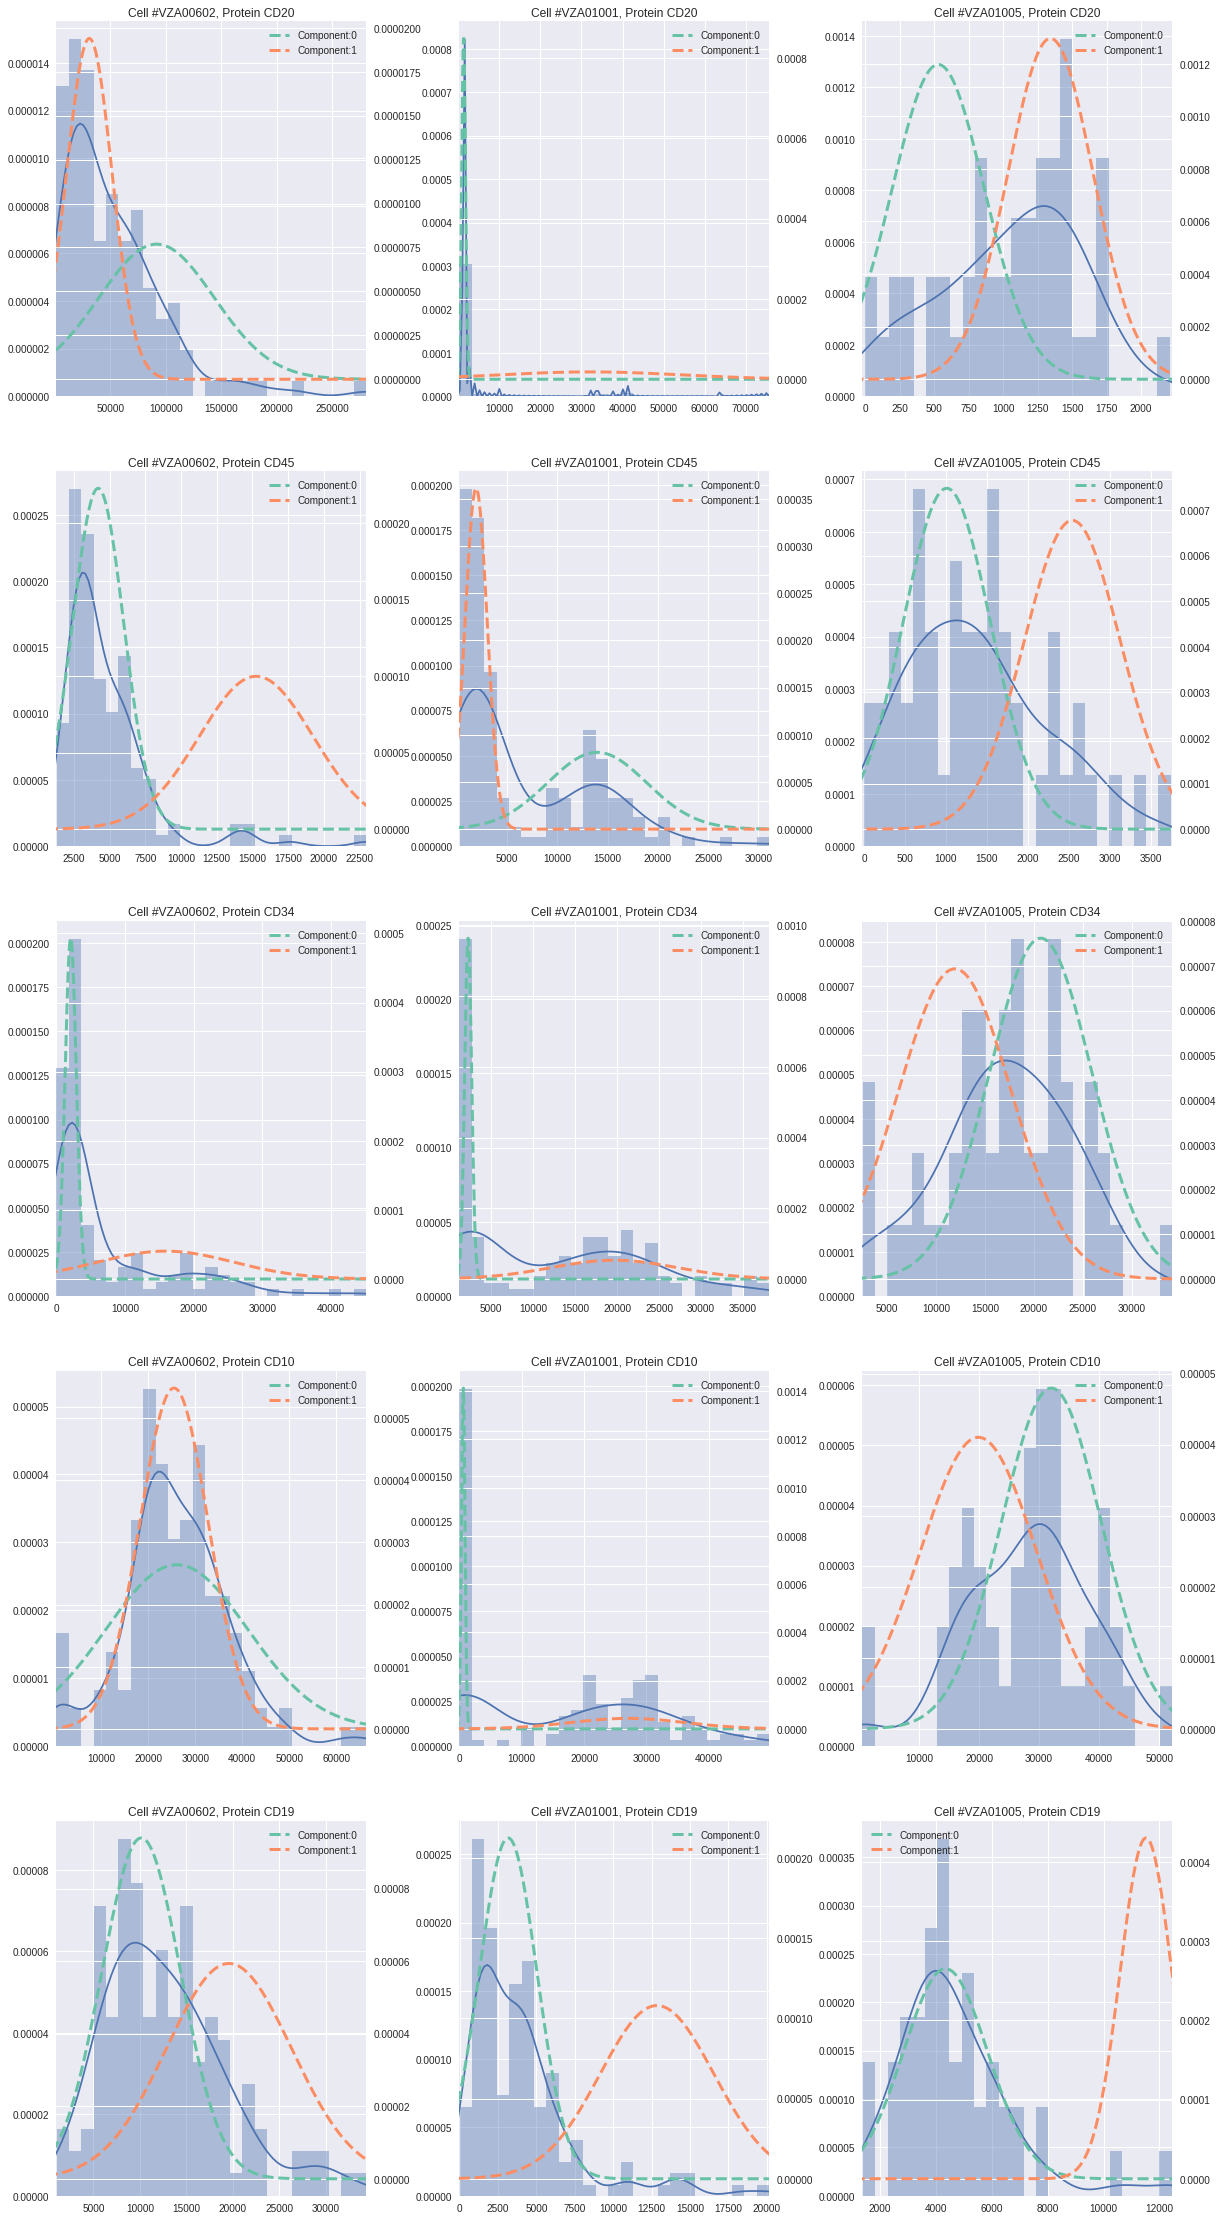

In [0]:
from sklearn.mixture import GaussianMixture
import matplotlib.mlab as mlab

n_components = 2

# setup ploting
colors = sns.color_palette(
    palette='Set2', n_colors=n_components)
plt.figure(figsize=(20, 40))


protein_types = protein.columns.values[1:6]
for i, protein_id in enumerate(protein_types):
  for j, cell_id in enumerate(protein.CellType.unique()):

    # select all data from given tank
    filtered_data = protein[protein.CellType == cell_id]
    protein_data = filtered_data[protein_id]

    # Fitting Gaussian on Pool data
    gmm = GaussianMixture(n_components=int(n_components),
                          covariance_type='diag', n_init=8,
                          random_state=5218)
    # the input data must be at least 2D, so we
    # need to do some preprocessing
    protein_data = np.atleast_2d(protein_data.values).T
    gmm.fit(protein_data)

    # Plotting the histogram
    plt.subplot(np.size(protein_types), np.size(protein.CellType.unique()),
                i * np.size(protein.CellType.unique()) + j + 1)
    sns.distplot(protein_data, bins=25)

    # Visualizing the GMM
    mean = gmm.means_.ravel()
    precision = gmm.precisions_.ravel()
    xmin, xmax = plt.gca().get_xlim()
    X = np.linspace(start=xmin, stop=xmax,
                    num=1000)

    ax = plt.gca().twinx()
    for n in range(n_components):
      Y = sp.stats.norm.pdf(X, mean[n], np.sqrt(1 / precision[n]))
      _, = ax.plot(X, Y,
                   label='Component:%d' % n,
                   color=colors[n], linewidth=3, linestyle='--')

    # show extra info
    ax.set_xlim((np.min(protein_data) - 20,
                 np.max(protein_data) + 20))
    plt.legend()
    plt.title("Cell #{0}, Protein {1}".format(cell_id, protein_id))
    
plt.subplots_adjust(wspace=0.3)

# Results
We see a grid of charts of cell type x protein. Each plot is the distribution of protein count for one type of cell. The green component represent the noise, the orange component represent the estimated actual count.

As we can see the GMM is now fitted to the data quite nicely in most of the case where the noise component the completely separed from the protein component and closer to zero. With this case we can easily specify the base line.


But, for some cases the separation is not obvious, there're some overlaps between the components.
In this case, to specify the baseline value, we have several options:
- If we want balanced separation, we chose the intersection of the two Gaussion is the value of the baseline
- If we want less false possitive: we move the baseline closer to the data component
- If we want less false negative: we move the baseline closer to the noise component

## Issue
Overall, the result is good, however, there's one case with cell VZA00602 and protein CD19, the two components are basically overlapped. This may require some more finishing and optimization for the model.

## Conclusion
By applying EM algorithm of Gaussian Mixture Model, we can infer the baseline value for protein count data in cells. Generally, the result was good, yet there is one minor issue to be improved.

I have achieved my goals for this project.

## Reference
1. https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html